Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 08/07/23\
Last modified: 09/07/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data, import_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie, plot_stack_bar
from utils.clean_data import PRODUCTS_VAL, translate_column, rename_columns, create_columns, clean_column
from utils.transform_data import estimate_weights, standard_company_name, create_wide_table
from utils.record_linkage import record_linkage, unique_matches, filter_crop, find_matches
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import numpy as np
from utils.map import top_subsidiaries, top_parent, filter_country
import re
import copy
import os

### HELPER FUNCTIONS

In [2]:
KNOW_COMPANIES = {"Kernel Holding S.A.": ["ДРУЖБА НОВА", "ЕНСЕЛКО АГРО", "ПОДІЛЛЯ АГРОСЕРВІС", "КЕРНЕЛ", "Kernel", "ТОВ ДРУЖБА 41300 СУМСЬКА ОБЛ М КРОЛЕВЕЦЬ ВУЛ КООПЕРАТИВНА БУД 3 Б"],
                  "UkrLandFarming PLC": ["VALINOR", "ДАКОР", "УКРЛЕНДФАРМІНГ", "ЮГТРАНЗИТСЕРВИС-АГРОПРОДУКТ", "АГРОКОМПАНІЯ ПРИКАРПАТТЯ", "UkrLandFarming"],
                  "MHP S.E.": ["МХП", "ТОВ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНІГОРОДСЬКИЙ Р Н СМТ ЄРКИ ВУЛ ГЕРОЇВ МАЙ", "MHP", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНИГОРОДСЬКИЙ Р Н СЕЛИЩЕ МІСЬКОГО ТИПУ ЄРКИ", "ТОВ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНИГОРОДСЬКИЙ Р Н СМТ ЄРКИ ВУЛ ГЕРОЇВ МАЙД"],
                  "TNA Corporate Solutions LLC": ["ПІВДЕНЬ АГРО ІНВЕСТ", "ПТАХОФАБРИКА ПОДІЛЛЯ", "ПРИДНІПРОВСЬКА", "РАЙЗ-МАКСИМКО", "ПРИДНІПРОВСЬКЕ", "TNA", "ТОВ ПОДІЛЛЯ АГРОПРОДУКТ 23130 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н СМТ БРАЇЛІВ ВУЛ ЗАВОДСЬКА Б"],
                  "NCH Capital Inc.": ["АГРОПРОСПЕРІС", "НХЦ", "NCH"],
                  "Astarta Holding": ["АСТАРТА", "ДОБРОБУТ", "ПОЛТАВАЗЕРНОПРОДУКТ", "ХМІЛЬНИЦЬКЕ", "АГРО КА", "Astarta", "Agrofirm named after Dovzhenko", "ТОВ АГРОФІРМА ІМ ДОВЖЕНКА 38030 ПОЛТАВСЬКА ОБЛ МИРГОРОДСЬКИЙ Р Н С ЯРЕСЬКИ ВУЛ КОЗАЦЬКИЙ ШЛ", "Volochysk-Agro", "ТОВ ВОЛОЧИСЬК АГРО 31200 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИЦЬКИЙ Р Н М ВОЛОЧИСЬК ВУЛ ФРИДРИХІВС"],
                  "Industrial Milk Company (IMC) S.A.": ["АГРОПРОГРЕС", "СЛОБОЖАНЩИНА АГРО", "АГРОКІМ", "БУРАТ АГРО", "ЛОСИНІВКА АГРО", "ИМЦ", "IMC"],
                  "Public Investment Fund (PIF) of Saudi Arabia": ["SALIC", "АГРО ЛВ", "МРІЯ ФАРМІНГ", "PIF", "ПИФ", "ТОВ СІЕФДЖІ ТРЕЙДИНГ УКРАЇНА 47602 ТЕРНОПІЛЬСЬКА ОБЛ ТЕРНОПІЛЬСЬКИЙ Р Н СМТ КОЗОВА ВУ"],
                  "Agroton Public Limited": ["АГРОТОН", "Agroton"],
                  "Nibulon": ["НІБУЛОН", "Nibulon"],
                  "System Capital Management (SCM)": ["АГРО ХОЛДИНГ МС", "System Capital Management", "SCM", "СЦМ"],
                  "Louis Dreyfus": ["Louis Dreyfus", "ТОВ ЛУЇ ДРЕЙФУС КОМПАНІ УКРАЇНА 01001 М КИЇВ ПЛОЩА СПОРТИВНА БЦ ГУЛІВЕР БУД 1 А ПОВЕРХ 15", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЛУЇ ДРЕЙФУС КОМПАНІ УКРАЇНА 01001 М КИЇВ ПЛОЩА СПОРТИВНА БЦ ГУЛІВЕР БУДИНОК 1 А ПОВЕРХ 15"],
                  "Cargill": ["Cargill", "ТОВ АТ КАРГІЛЛ 03150 УКРАЇНА М КИЇВ ВУЛИЦЯ ВЕЛИКА ВАСИЛЬКІВСЬКА БУД 139", "ТОВ АТ КАРГІЛЛ 03150 УКРАЇНА М КИЇВ ВУЛ ВЕЛИКА ВАСИЛЬКІВСЬКА БУД 139", "ТОВ АТ КАРГІЛЛ 03150 М КИЇВ ВУЛ ВЕЛИКА ВАСИЛЬКІВСЬКА БУД 139"],
                  "Glencore": ["Glencore"],
                  "Marubeni": ["Marubeni"],
                  "Bunge": ["Bunge"],
                  "Noble Resources": ["Noble Resources"],
                  "Viterra Ukraine": ["Viterra", "ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ ВАЙТЕРРА УКРАЇНА 03150 МІСТО КИЇВ ВУЛ ВЕЛИКА ВАСИЛЬКІВСЬКА БУДИНОК 100"],
                  "Ardeon Tsentr": ["Ardeon", "ТОВ АРДЕОН ЦЕНТР 07301 КИЇВСЬКА ОБЛ М ВИШГОРОД ВУЛ ВАТУТІНА БУД 69 Г ОФІС 2/4"],
                  "Allseeds Group": ["Allseeds", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОЛСІДЗ ГРУП УКРАЇНА 04655 М КИЇВ ВУЛ ВЕРХНІЙ ВАЛ БУД 72"],
                  "Delta Wilmar Ukraine": ["Delta Wilmar Ukraine", "ТОВ ДЕЛЬТА ВІЛМАР УКРАЇНА 65481 ОДЕСЬКА ОБЛ МІСТО ЮЖНЕ ВУЛИЦЯ ІНДУСТРІАЛЬНА БУДИНОК 6"],
                  "Bioenergy-Vinnytsia": ["Bioenergy-Vinnytsia", "ТОВ БІОЕНЕРДЖІ ВІННИЦЯ 23130 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н СМТ БРАЇЛІВ ВУЛ ЗАВОДСЬКА БУ"],
                  "SFGCU": ["State Food and Grain Corporation of Ukraine", "АКЦІОНЕРНЕ ТОВАРИСТВО ДЕРЖАВНА ПРОДОВОЛЬЧО ЗЕРНОВА КОРПОРАЦІЯ УКРАЇНИ 01033 М КИЇВ ВУЛ САКСАГАНСЬКОГО 1", "SFGCU"],
                  "Karla Marksa 2": ["Karla Marksa", "ПП КАРЛА МАРКСА 2 41543 СУМСЬКА ОБЛ КОНОТОПСЬКИЙ РАЙОН С МІНАКОВЕ ВУЛ САДОВА БУД 6"],
                  "Optimus Agro": ["Optimus Agro", "ТОВ ОПТІМУСАГРО ТРЕЙД 49033 ДНІПРОПЕТРОВСЬКА ОБЛ М ДНІПРО ПР Т БОГДАНА ХМЕЛЬНИЦЬКОГО Б", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОПТІМУСАГРО ТРЕЙД 69014 ЗАПОРІЗЬКА ОБЛ МІСТО ЗАПОРІЖЖЯ ВУЛ ХАРЧОВА БУДИНОК 3"],
                  "Archer Daniels Midland": ["ADM Ukraine", "Archer Daniels Midland", "ТОВ АДМ ЮКРЕЙН 04070 М КИЇВ ВУЛ ПЕТРА САГАЙДАЧНОГО БУД 16 А УКРАЇНА", "ТОВ АДМ ЮКРЕЙН УКРАЇНА 04070 М КИЇВ ПОДІЛЬСЬКИЙ Р Н ВУЛ ПЕТРА САГАЙДАЧНОГО БУД 16 А"],
                  "Ossoyo": ["Ossoyo", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОССОЙО УКРАЇНА 01054 МІСТО КИЇВ ВУЛ ГОНЧАРА ОЛЕСЯ БУДИНОК 35 ПРИМІЩЕННЯ", "ОССОЙО"],
                  "D.Trading": ["D.Trading", "ТОВ Д ТРЕЙДІНГ 04119 М КИЇВ ВУЛИЦЯ ХОХЛОВИХ СІМ Ї БУДИНОК 8 ЛІТЕРА 20Д"],
                  "HS Airlines": ["HS Airlines", "ТОВ ЕЙЧ ЕС ЕЙРЛАЙНС 65039 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ ТРАНСПОРТНА БУД 5/1"],
                  "Willers": ["Willers", "ТОВ ВІЛЕРС 04053 М КИЇВ ВОЗНЕСЕНСЬКИЙ УЗВІЗ БУД 14 ОФ 16/7"],
                  "Nimeri Hold": ["Nimeri Hold", "ТОВ НІМЕРІ ГОЛД 65048 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ КАНАТНА БУД 42 ОФ 975"],
                  "Smartsystems": ["Smartsystems", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СМАРТСИСТЕМС 54003 МИКОЛАЇВСЬКА ОБЛ М МИКОЛАЇВ ПР ЦЕНТРАЛЬНИЙ БУДИНОК 269/3"],
                  "New Logist Ukraine": ["New Logist Ukraine", "ТОВ НЬЮ ЛОГІСТ ЮКРЕЙН 65005 М ОДЕСА ВУЛ БАЛКІВСЬКА БУД 108 КАБ 27", "ТОВ НЬЮ ЛОГІСТ ЮКРЕЙН 65005 УКРАЇНА М ОДЕСА ВУЛ БАЛКІВСЬКА 108 КАБ 27"],
                  "Trade Westend": ["Trade Westend", "ТОВ ТРЕЙД ВЕСТЕНД 79007 М ЛЬВІВ ВУЛ ШПИТАЛЬНА БУД 9 УКРАЇНА"],
                  "Verkhivtsevsky Oil Extraction Plant 'Soloma'": ["Verkhivtsevsky Oil Extraction Plant", "Soloma", "ТОВ СОЛОМА 51660 ДНІПРОПЕТРОВСЬКА ОБЛ ВЕРХНЬОДНІПРОВСЬКИЙ Р ОН М ВЕРХІВЦЕВЕ"],
                  "Korsun-Shevchenkivsky Grain Reception Enterprise": ["Korsun-Shevchenkivsky Grain Reception Enterprise", "ТОВ КОРСУНЬ ШЕВЧЕНКІВСЬКЕ ХЛІБОПРИЙМАЛЬНЕ ПІДПРИЄМСТВО 19402 ЧЕРКАСЬКА ОБЛ М КОРСУНЬ ШЕВЧ ЕНКІВСЬКИЙ ПРОВ ПРОМИСЛОВИЙ БУД 6"],
                  "Tolans": ["Tolans", "ТОВ СТИВІДОРНА КОМПАНІЯ ОКТЯБРЬСКА УКРАЇНА 57214 МИКОЛАЇВСЬКА ОБЛ ВІТОВСЬКИЙ Р Н СЕЛО МІШКОВО ПОГОРІ", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СТИВІДОРНА КОМПАНІЯ ОКТЯБРЬСК 57214 МИКОЛАЇВСЬКА ОБЛАСТЬ ВІТОВСЬКИЙ РАЙОН СЕЛО МІШКОВО ПОГОРІЛОВЕ"],
                  "TH Novaagro": ["TH Novaagro", "ТОВ ТБ НОВААГРО 61002 М ХАРКІВ ВУЛ ЧЕРНИШЕВСЬКА БУД 66"],
                  "Analytictrade": ["Analytictrade", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АНАЛІТИКТРЕЙД 54001 МИКОЛАЇВСЬКА ОБЛ МІСТО МИКОЛАЇВ ВУЛ ШЕВЧЕНКА БУД 71 ОФІС"],
                  "New Agro Podillya LLC": ["New Agro Podillya", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НЬЮ АГРО ПОДІЛЛЯ 32207 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИЦЬКИЙ РН С ЯБЛУНІВКА ПРОВ МИРУ БУД 1"],
                  "Group of companies Vitagro LLC": ["Vitagro", "ПП АГРАРНА КОМПАНІЯ 2004 31222 УКРАЇНА ХМЕЛЬНИЦЬКА ОБЛ ВОЛОЧИСЬКИЙ Р Н С ПОПІВЦІ ВУЛ ШК"],
                  "Eridon PE": ["Eridon", "ТОВ ФІРМА ЕРІДОН 08467 КИЇВСЬКА ОБЛ ПЕРЕЯСЛАВ ХМЕЛЬНИЦЬКИЙ Р Н С ЧОПИЛКИ ВУЛ БОГДА"],
                  "Vesele-Agro LLC": ["Vesele-Agro", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВЕСЕЛЕ АГРО УКРАЇНА 45611 ВОЛИНСЬКА ОБЛ ЛУЦЬКИЙ Р Н СЕЛО ВЕСЕЛЕ ВУЛ ТОРЧИНС"],
                  "Kurland": ["Kurland", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КУРЛАНД УКРАЇНА 23152 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н С ТЕЛЕЛИНЦІ ВУЛ ЦЕН"],
                  "Vorozhbalatinvest LLC": ["Vorozhbalatinvest", "ТОВ ВОРОЖБАЛАТІНВЕСТ 42240 СУМСЬКА ОБЛ ЛЕБЕДИНСЬКИЙ РАЙОН С ВОРОЖБА ВУЛ СУМСЬКА БУД 1"],
                  "MIR 12": ["MIR 12", "ТОВ МИР 12 41532 СУМСЬКА ОБЛ КОНОТОПСЬКИЙ Р Н С МАЗІВКА ВУЛ МИРУ БУД 14"],
                  "Promin Podillya LLC": ["Promin Podillya", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ПРОМІНЬ ПОДІЛЛЯ УКРАЇНА 32625 ХМЕЛЬНИЦЬКА ОБЛ НОВОУШИЦЬКИЙ Р Н СЕЛО ПЕСЕЦЬ ВУЛ"],
                  "Olyshchivka": ["Olyshchivka", "ТОВ ОЛИШІВКА 15575 ЧЕРНІГІВСЬКА ОБЛ ЧЕРНІГІВСЬК Р Н СМТ ОЛИШІВКА В ЧЕРНІГІВСЬКА Б"],
                  "Ukrainian Agricultural Enterprise": ["Ukrainian Agricultural Enterprise", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМС 54002 УКРАЇНА М МИКОЛАЇВ ВУЛ КАБОТАЖНИЙ СПУСК 1"],
                  "Fin-Invest Polissia": ["Fin-Invest Polissia", "ТОВ ФІН ІНВЕСТ ПОЛІССЯ УКРАЇНА 11720 ЖИТОМИРСЬКА ОБЛ НОВОГРАД ВОЛИНСЬКИЙ Р Н С КУРЧИЦЯ"],
                  "Krauka": ["Krauka", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КРАУКА 65031 ОДЕСЬКА ОБЛ МІСТО ОДЕСА ВУЛ ХІМІЧНА БУДИНОК 1/2"],
                  "Systemy Transportnykh Pokryttiv": ["Systemy Transportnykh Pokryttiv", "ТОВ СИСТЕМИ ТРАНСПОРТНИХ ПОКРИТТІВ УКРАЇНА 68000 ОДЕСЬКА ОБЛ М ЧОРНОМОРСЬК ВУЛ ТРАНСПОРТНА БУД 9"],
                  "Trepfin": ["Trepfin", "ТОВ ТРЕПФІН 03150 М КИЇВ ВУЛ ПРЕДСЛАВИНСЬКА БУД 34 Б"],
                  "Likhachevsky Elevator": ["Likhachevsky Elevator", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЛИХАЧОВСЬКИЙ ЕЛЕВАТОР 64107 ХАРКІВСЬКА ОБЛ ЛОЗІВСЬКИЙ Р Н МІСТО ПЕРВОМАЙСЬКИЙ ПРОВ ЛІС"],
                  "COFCO": ["Cofco", "ТОВ КОФКО АГРІ РЕСОРСІЗ УКРАЇНА 01133 М КИЇВ ВУЛ ЄВГЕНА КОНОВАЛЬЦЯ БУД 32 Б ОФІС 1019 УКРАЇНА"],
                  "Holdfins Layt": ["Holdfins Layt", "ТОВ ГОЛДФІНС ЛАЙТ 03187 УКРАЇНА М КИЇВ ВУЛ ЗАБОЛОТНОГО АКАДЕМІКА БУД 48А"],
                  "Olam Ukraine": ["Olam Ukraine", "ТОВ ОЛАМ УКРАЇНА 03057 М КИЇВ ВУЛ МЕТАЛІСТІВ БУД 20 ЛІТ Т"]}

ASIAN_COUNTRIES = {"india": "індія", "viet nam": "в єтнам",
                   "sri lanka": "шрі ланка"}

def correct_name(series, name_dict):
    """
    Update column values from a dataframe with correct ones.

    Inputs:
        series (Series): column we want to update
        name_dict (dict): dictionary with incorrect names as keys and correct
            names as values.
    
    Returns: series with correct names.
    """
    return series.apply(lambda x: name_dict[x])

def filter_country(deals, country):
    """
    Filter land deals for a specific country

    Inputs:
        deals (DataFrame): dataframe with land deals data
        country (str): country name

    Returns (DataFrame): dataframe with country land locations
    """
    deals_c = deals.copy()
    deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
    deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains(country.lower(),
                                                                     na=False)]
    
    return deals_c

def extend_list(list, character):
    """
    Create new list with split text based on "character" parameter

    Inputs:
        list (lst): list of strings
        character (str): character to use to separate string values in list

    Returns (lst): new list with split text based on "character" parameter
    """
    new_lst = []
    for value in list:
        new_lst += value.split(character)

    return new_lst

def clean_list(list, pattern):
    """
    Create new list with clean text based on "pattern" parameter

    Inputs:
        list (lst): list of strings
        pattern (str): pattern we want to find and replace in each string value
            on the list

    Returns (lst): None. Makes changes in place in input "list".
    """
    for i, value in enumerate(list):
        match = re.search(pattern, value)
        if match:
            list[i] = match.group(0)

def parent_subsidiary_dict(parent_lst, deals_data, n_subsidiaries):
    """
    Create dictionary with parent companies as keys and subsidaries as values.

    Inputs:
        parent_lst (lst): list of parent companies
        deals_data (DataFrame): deals dataframe where we're going to look for
            subsidiaries
        n_subsidiaries (int): number of subsidiaries we want to get for parent
            company.

    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    subsidiaries_dict = {}

    for parent in parent_lst:
        subsidiaries_dict[parent] = top_subsidiaries(deals_data, parent,
                                                     n_subsidiaries)

    return subsidiaries_dict

def translate_subsidiaries(dict, source_lan, target_lan):
    """
    Create dictionary with translated subsidiaries' names as values.

    Inputs:
        dict (dict): dictionary with subsidarie names in English
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    d_target = {}

    for parent, sub_lst in dict.items():
        target_lst = []
        for subsidiary in sub_lst:
            target_lst.append(GoogleTranslator(source_lan, target_lan).\
                              translate(subsidiary))
        d_target[parent] = target_lst

    return d_target

def manually_add_subsidiaries(original_dict, manual_dict):
    """
    Add subsidaries manually as values to company dictionary.

    Inputs:
        manual_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    for parent, subsidiary_lst in manual_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()
        if parent in original_dict:
            original_dict[parent] += manual_dict[parent]
        else:
            original_dict[parent] = manual_dict[parent]

    return original_dict

def dict_to_lower(dict):
    """
    Convert dictionary values of 'dict' to lowercase

    Inputs:
        dict (dict): dictionary with parent companies as keys and subsidaries
            as values.

    Returns (dict): None. The function does the change in place of the input
        'dict'.
    """
    for parent, subsidiary_lst in dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()

def add_companies_manually(old_dict, new_dict):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): None. The function does the change in place of the input
        'old_dict'.
    """
    for parent, subsidiary_lst in new_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()

        if parent in old_dict:
            old_dict[parent] += new_dict[parent]
        else:
            old_dict[parent] = new_dict[parent]

def estimate_table_percentages(table):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): None. The function does the change in place of the input
        'old_dict'.
    """
    table = table.fillna(0)
    date = table["date"]
    percentage_df = table.drop(columns=["date"]).divide(table.drop(columns=\
                                            ["date"]).sum(axis=1), axis=0) * 100
    percentage_df = percentage_df.round(2)
    percentage_df["date"] = date
    
    return percentage_df

def plot_multiple_countries(country_dict, data, y_axis_limit, source):
    """
    Plot stacked bar charts for more than one country

    Inputs:
        country_dict (dict): dictionary with country names in BSGI as keys
            (in English) and country names in IG as values (Ukrainian)
        data (DataFrame): dataset with information to plot
        y_axis_limit (int): y axis limit in scale
        source (str): text to say which is the data source for the plot.

    Returns (dict): None. The function plots the stacked bar charts.
    """
    for country_en, country_uk in country_dict.items():
        ig_country = data[data["country"] == country_uk]
        pivot_country = create_wide_table(ig_country,
                                          ["year", "month", "company_std"],
                                          ["weight_ton"],
                                          ["year", "month", "company_std"], True,
                                          {"weight_ton": "sum"})
        plot_stack_bar(pivot_country, "Total exports by company",
                       "Weight of exports (metric tons)",
                       f"Total exports to {country_en.capitalize()} by company",
                       "date", y_axis_limit, source)

def plot_all_period(data, source, min_wedge_percentage=2,
                    min_legend_percentage=0):
    """
    Plot a pie chart to estimate the export shares for the whole period of time
        (August 2022 until March 2023), not by month.

    Inputs:
        data (DataFrame): dataset with information to plot
        source (str): text to say which is the data source for the plot
        min_wedge_percentage (float, optional): minimum percentage threshold for
            annotating wedges (default is 2)
        min_legend_percentage (float, optional): minimum percentage threshold
            for adding wedges legend (default is 0).

    Returns (dict): None. The function plots the pie chart.
    """
    whole_period_g = cargo_grouping(data, ["company_std"], ["weight_ton"],
                                    ["weight_ton"], False, {"weight_ton": "sum"})
    whole_period_g = whole_period_g.reset_index(drop=True)
    plot_pie(whole_period_g["company_std"], whole_period_g["weight_ton"],
             "Company category",
             "Share of exports (metric tons) exported by company", source,
             min_wedge_percentage, min_legend_percentage)

We get the data from IG for Asian countries and from BSGI for all countries

In [3]:
current_dir = os.getcwd()
path = os.path.join(os.path.dirname(current_dir), "data/ig_spain_22-23.csv")
ig_asia = get_data("ig", path)
bsgi = get_data("bsgi")

In [4]:
ig_asia["country"].unique()

array(['іспанія'], dtype=object)

We transform the country strings to the correct ones manually. This should be done
after doing record linkage but since we're not doing that we'll do it manually and then add it to
a function.

In [5]:
# name_dict = {"в'єтнам": "в єтнам", "в єтнам": "в єтнам", "індія": "індія", "шрі-ланка": "шрі ланка", "шрі ланка": "шрі ланка"}
# ig_asia["country"] = correct_name(ig_asia["country"], name_dict)
# ig_asia["country"].unique()

Now we filter just exports for crops that are included in BSGI so we can compare the volumes (otherwise we'll include exports for other commodities like metals that are included in IG but that aren't included in BSGI)

In [6]:
ig_asia = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]

print("IG tons:",ig_asia.loc[ig_asia.loc[:, "country"] == "іспанія"]["weight_ton"].sum())
print("BSGI tons:",bsgi.loc[bsgi.loc[:, "country_en"] == "spain"]["weight_ton"].sum())

IG tons: 4653571.603
BSGI tons: 5980657


We filter the BSGI data to include only months that are included in our IG data (August 2022 until March 2023)

In [7]:
bsgi_asia = bsgi[(bsgi["date"] >= "2022-08-01") & (bsgi["date"] < "2023-04-01") & ((bsgi["country_en"] == "spain"))]
bsgi_asia.head()

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
169,Outbound,858,SANITA S,9237888,Chornomorsk,spain,corn,40500,2023-03-30,7-Apr-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,corn,1005,кукурудза,іспанія
172,Outbound,855,XIN YU,9244362,Chornomorsk,spain,corn,27671,2023-03-29,8-Apr-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,corn,1005,кукурудза,іспанія
185,Outbound,845,FAIR LADY,9342877,Chornomorsk,spain,corn,45044,2023-03-25,4-Apr-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,corn,1005,кукурудза,іспанія
203,Outbound,829,NEW ISLAND,9258349,Chornomorsk,spain,corn,42000,2023-03-20,29-Mar-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,corn,1005,кукурудза,іспанія
206,Outbound,827,SSI PRIDE,9250579,Chornomorsk,spain,wheat,47000,2023-03-19,28-Mar-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,wheat,1001,пшениця,іспанія


## TOTAL EXPORTS BY COMPANY

### STACKED BAR CHARTS

We have to create a column with standardized company names.

We're going to first get a list of the top 25 companies controlling agricultural land in Ukraine

In [8]:
deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
deals_c = filter_country(deals, "ukraine")
parent_lst = top_parent(deals_c, 25)
parent_lst = extend_list(parent_lst, "|")

pattern = r'^.*?(?=#\d+#)'
clean_list(parent_lst, pattern)
parent_lst

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_50214/180980090.py:1: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")


['KSG Agro SA',
 'Xinjiang Production and Construction Corps (XPCC)',
 'China National Corporation for Overseas Economic Cooperation',
 'China-Ukraine International Engineering Cooperation Association Ltd.',
 'Kernel Holding S.A.',
 'UkrLandFarming PLC',
 'TNA Corporate Solutions LLC',
 'NCH Capital Inc.',
 'Ivanchyk V.P.',
 'Fairfax Financial Holdings LTD',
 'Sintal Agriculture Plc',
 'Public Investment Fund (PIF) of Saudi Arabia',
 'MHP S.E.',
 'Industrial Milk Company (IMC)',
 'System Capital Management (SCM)',
 'Smart Holding',
 'Agroton Public Limited',
 'MCB Agricole',
 'JSC "TAS Group"',
 'Myronivsky Hliboproduct PJSC',
 'MHP S.E.',
 'Nibulon',
 'SAS Investcompagnie',
 'UkrLandFarming PLC',
 'Extrar Holding Limeted',
 'YUTS-Agroproduct LLC',
 'Agro Ukraina AB',
 'Industrial Milk Company (IMC) S.A.',
 'Fintest trading co limited',
 'Ivory trade ITD.',
 'Inkosteel group LLC',
 'Renvior Trading Limited',
 'Epicentr-K LLC',
 'Logistical centre Kalynivka PJSC',
 'Nova Linia PJSC',
 '

Then we get a dictionary with the top 25 parent companies as keys and the top 20 subsidaries controlling agricultural land in Ukraine as values.

First we create the dictionary with the subsidiary names in English.

In [9]:
subsidiaries_dict = parent_subsidiary_dict(parent_lst, deals_c, 20)
subsidiaries_dict

/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str

{'KSG Agro SA': array(['Unknown (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))',
        'KSG Dnipro', 'Souz-3 LLC', 'Argo-Golden LLC'], dtype=object),
 'Xinjiang Production and Construction Corps (XPCC)': array([], dtype=object),
 'China National Corporation for Overseas Economic Cooperation': array(['Unknown (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
       dtype=object),
 'China-Ukraine International Engineering Cooperation Association Ltd.': array(['Unknown (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
       dtype=object),
 'Ker

In [10]:
subsidiaries_uk = translate_subsidiaries(subsidiaries_dict, "en", "uk")
subsidiaries_uk

{'KSG Agro SA': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))',
  'КСГ Дніпро',
  'ТОВ «Союз-3».',
  'ТОВ «Арго-Голден».'],
 'Xinjiang Production and Construction Corps (XPCC)': [],
 'China National Corporation for Overseas Economic Cooperation': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
 'China-Ukraine International Engineering Cooperation Association Ltd.': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
 'Kernel Holding S.A.': ['Невідомо (Kernel Holding S.A., Україна, 38098)',
  'ТОВ «Дружба Нова».

Now we turn the values of the subsidiaries dictionary to lower case, as well as the shipper column in IG


In [11]:
dict_to_lower(subsidiaries_uk)
ig_asia["shipper_low"] = ig_asia["shipper"].str.lower()
subsidiaries_uk

{'KSG Agro SA': ['невідомо (china national corporation for overseas economic cooperation, china-ukraine international engineering cooperation association ltd., ksg agro sa, xinjiang production and construction corps (xpcc))',
  'ксг дніпро',
  'тов «союз-3».',
  'тов «арго-голден».'],
 'Xinjiang Production and Construction Corps (XPCC)': [],
 'China National Corporation for Overseas Economic Cooperation': ['невідомо (china national corporation for overseas economic cooperation, china-ukraine international engineering cooperation association ltd., ksg agro sa, xinjiang production and construction corps (xpcc))'],
 'China-Ukraine International Engineering Cooperation Association Ltd.': ['невідомо (china national corporation for overseas economic cooperation, china-ukraine international engineering cooperation association ltd., ksg agro sa, xinjiang production and construction corps (xpcc))'],
 'Kernel Holding S.A.': ['невідомо (kernel holding s.a., україна, 38098)',
  'тов «дружба нова».

Manually add some companies

In [12]:
subsidiaries_c = copy.deepcopy(subsidiaries_uk)
add_companies_manually(subsidiaries_c, KNOW_COMPANIES)
subsidiaries_c["Kernel Holding S.A."]

['невідомо (kernel holding s.a., україна, 38098)',
 'тов «дружба нова».',
 'тов «придніпровський край».',
 'тов «енселко агро».',
 'невідомо (kernel holding s.a., україна, 35574)',
 'тов «поділля-агросервіс».',
 'тов «калина».',
 'тов «вишневе-агро».',
 'ховтва allc',
 'тов «агрополіс».',
 'тов "агрофірма семереньки".',
 'тов «агропідприємство рост».',
 'тов «агрофірма «україна».',
 'агро інвест україна',
 'пп старший',
 'тов «кочубій».',
 'пп куликівські аграрні інвестиції',
 'тов «агрофірма кочубій».',
 'київська русь верфель тов',
 'тов «агрофірма «вісла».',
 'дружба нова',
 'енселко агро',
 'поділля агросервіс',
 'кернел',
 'kernel',
 'тов дружба 41300 сумська обл м кролевець вул кооперативна буд 3 б']

In [13]:
ig_c = ig_asia.copy()
ig_c["company_std"] = standard_company_name(ig_asia["shipper_low"], subsidiaries_c)
ig_c["company_std"].unique()

array(['Other', 'Viterra Ukraine', 'Likhachevsky Elevator',
       'Archer Daniels Midland', 'MHP S.E.', 'COFCO',
       'Ukrainian Agricultural Enterprise', 'KSG Agro SA',
       'Astarta Holding', 'Group of companies Vitagro LLC',
       'Kernel Holding S.A.', 'Willers', 'NCH Capital Inc.',
       'Systemy Transportnykh Pokryttiv',
       'Public Investment Fund (PIF) of Saudi Arabia',
       'Industrial Milk Company (IMC) S.A.', 'New Logist Ukraine',
       'Cargill', 'Louis Dreyfus', 'MIR 12', 'Olyshchivka',
       'Fin-Invest Polissia', 'UkrLandFarming PLC', 'Karla Marksa 2',
       'Ardeon Tsentr', 'Holdfins Layt', 'Krauka',
       'New Agro Podillya LLC', 'System Capital Management (SCM)',
       'Burat-Agro LLC', 'Trepfin', 'Agroton Public Limited', 'Nibulon',
       'Olam Ukraine', 'Allseeds Group', 'Vorozhbalatinvest LLC',
       'TH Novaagro'], dtype=object)

Now we convert the dataframe to a wide format so we can plot the stacked bar.

In [14]:
pivot = create_wide_table(ig_c, ["year", "month", "company_std"], ["weight_ton"], ["year", "month", "company_std"], True, {"weight_ton": "sum"})
pivot

company_std,date,Agroton Public Limited,Allseeds Group,Archer Daniels Midland,Ardeon Tsentr,Astarta Holding,Burat-Agro LLC,COFCO,Cargill,Fin-Invest Polissia,...,Public Investment Fund (PIF) of Saudi Arabia,System Capital Management (SCM),Systemy Transportnykh Pokryttiv,TH Novaagro,Trepfin,UkrLandFarming PLC,Ukrainian Agricultural Enterprise,Viterra Ukraine,Vorozhbalatinvest LLC,Willers
6,8/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16871.7,NaN,NaN
7,9/2022,NaN,NaN,118599.7,NaN,NaN,NaN,NaN,23036.4,NaN,...,4538.4,NaN,NaN,1368.3,7736.0,1508.5,NaN,43690.7,NaN,NaN
1,10/2022,NaN,4423.5,66659.2,NaN,683.9,NaN,NaN,30023.9,NaN,...,8199.0,NaN,NaN,652.4,28098.5,NaN,NaN,29542.6,6805.1,NaN
2,11/2022,1597.7,NaN,58132.5,NaN,16722.4,3465.8,NaN,NaN,NaN,...,13418.6,NaN,NaN,NaN,604.7,NaN,NaN,53295.9,NaN,NaN
3,12/2022,NaN,NaN,44056.1,2651.9,3536.3,3210.1,2780.0,509.5,23106.0,...,NaN,420.3,NaN,NaN,NaN,NaN,NaN,46688.3,NaN,NaN
0,1/2023,NaN,NaN,NaN,NaN,3419.8,NaN,NaN,34790.4,16412.1,...,5263.4,NaN,NaN,NaN,NaN,1406.8,32700.0,NaN,NaN,NaN
4,2/2023,NaN,NaN,NaN,NaN,13596.5,NaN,NaN,23281.4,NaN,...,2504.3,NaN,NaN,NaN,NaN,NaN,NaN,14248.0,NaN,NaN
5,3/2023,NaN,NaN,17879.1,NaN,909.2,NaN,30479.5,NaN,NaN,...,NaN,NaN,37459.8,NaN,NaN,NaN,43906.5,27072.1,NaN,13076.0


Now we do the same but we estimate the percentages of the wide table

In [15]:
percentages = pivot.copy()
percentages_df = estimate_table_percentages(percentages)
percentages_df

company_std,Agroton Public Limited,Allseeds Group,Archer Daniels Midland,Ardeon Tsentr,Astarta Holding,Burat-Agro LLC,COFCO,Cargill,Fin-Invest Polissia,Group of companies Vitagro LLC,...,System Capital Management (SCM),Systemy Transportnykh Pokryttiv,TH Novaagro,Trepfin,UkrLandFarming PLC,Ukrainian Agricultural Enterprise,Viterra Ukraine,Vorozhbalatinvest LLC,Willers,date
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,58.93,0.00,0.00,8/2022
7,0.00,0.00,13.88,0.00,0.00,0.00,0.00,2.70,0.00,0.00,...,0.00,0.00,0.16,0.91,0.18,0.00,5.11,0.00,0.00,9/2022
1,0.00,0.69,10.46,0.00,0.11,0.00,0.00,4.71,0.00,0.00,...,0.00,0.00,0.10,4.41,0.00,0.00,4.64,1.07,0.00,10/2022
2,0.29,0.00,10.41,0.00,3.00,0.62,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.11,0.00,0.00,9.55,0.00,0.00,11/2022
3,0.00,0.00,5.07,0.31,0.41,0.37,0.32,0.06,2.66,0.00,...,0.05,0.00,0.00,0.00,0.00,0.00,5.37,0.00,0.00,12/2022
0,0.00,0.00,0.00,0.00,0.69,0.00,0.00,7.02,3.31,0.00,...,0.00,0.00,0.00,0.00,0.28,6.60,0.00,0.00,0.00,1/2023
4,0.00,0.00,0.00,0.00,2.58,0.00,0.00,4.42,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,2.70,0.00,0.00,2/2023
5,0.00,0.00,2.62,0.00,0.13,0.00,4.46,0.00,0.00,0.27,...,0.00,5.48,0.00,0.00,0.00,6.42,3.96,0.00,1.91,3/2023


Now we plot the stacked bar with our wide format table we created earlier.

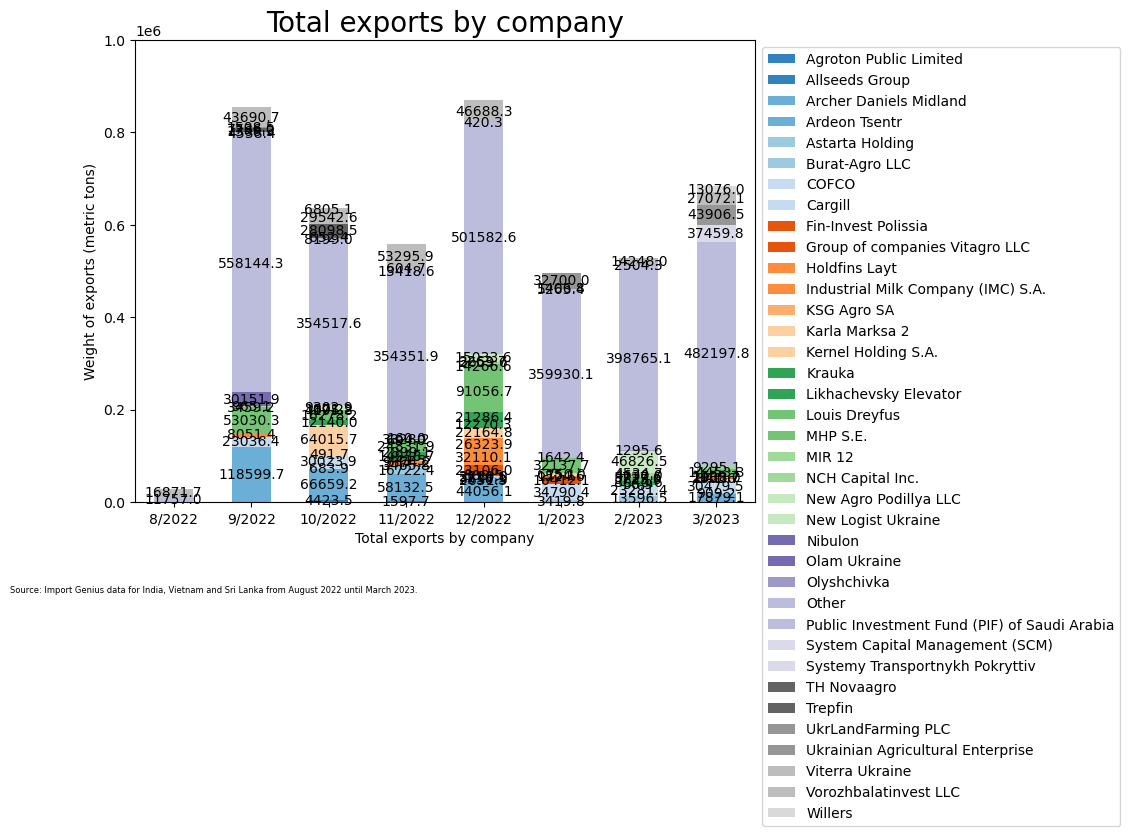

In [16]:
plot_stack_bar(pivot, "Total exports by company", "Weight of exports (metric tons)", "Total exports by company", "date", 1000000, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

Now we do the same but with percentages

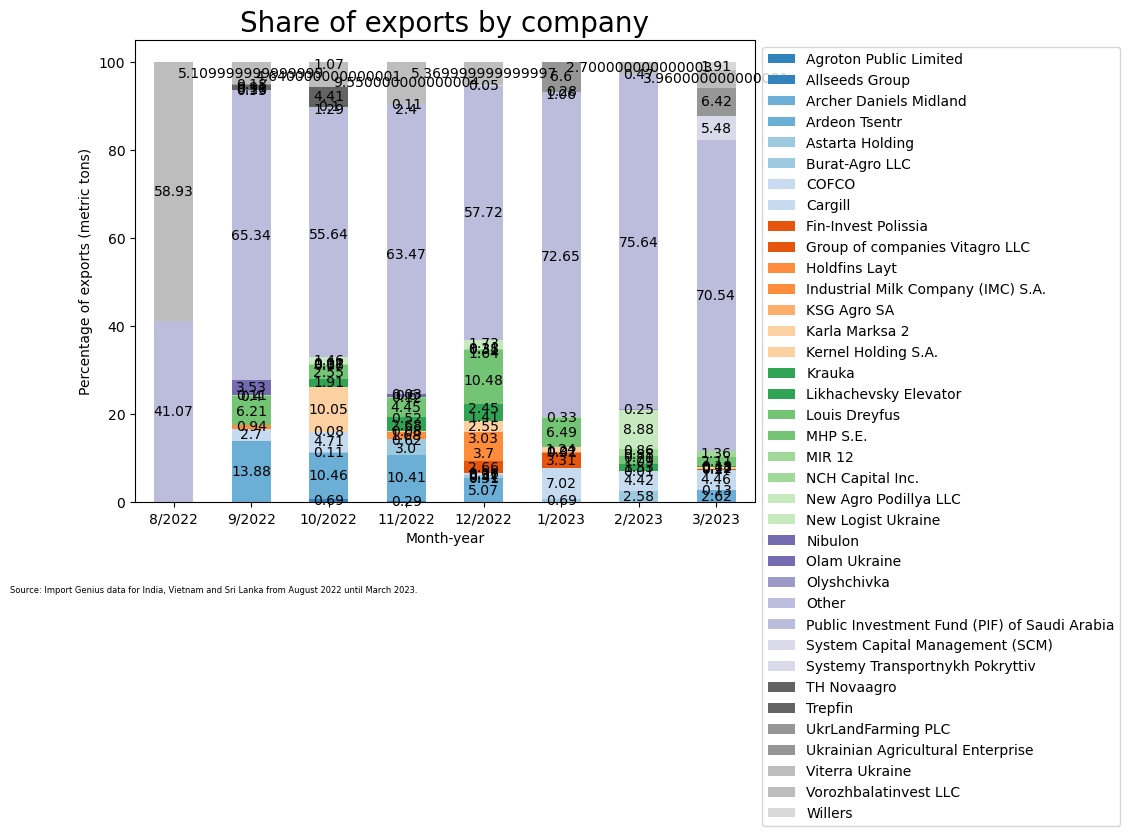

In [17]:
plot_stack_bar(percentages_df, "Month-year", "Percentage of exports (metric tons)", "Share of exports by company", "date", 105, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

Now we plot the same stacked bars with percentages but for the whole period of August 2022 until March 2023.

Values passed to ax.pie:
 0     3021246.379
1      305326.560
2      231409.341
3      223059.678
4      111641.562
5       95709.952
6       76606.540
7       71163.033
8       45330.929
9       40092.420
10      39518.080
11      39349.000
12      38868.115
13      37459.777
14      36439.186
15      33923.755
16      33425.695
17      33259.500
18      32110.109
19      30311.900
20      20862.013
21      13075.962
22       6805.147
23       6675.825
24       4630.000
25       4423.531
26       3343.869
27       3328.175
28       2915.337
29       2651.900
30       2020.710
31       1865.670
32       1597.730
33       1295.600
34        841.568
35        566.795
36        420.260
Name: weight_ton, dtype: float64


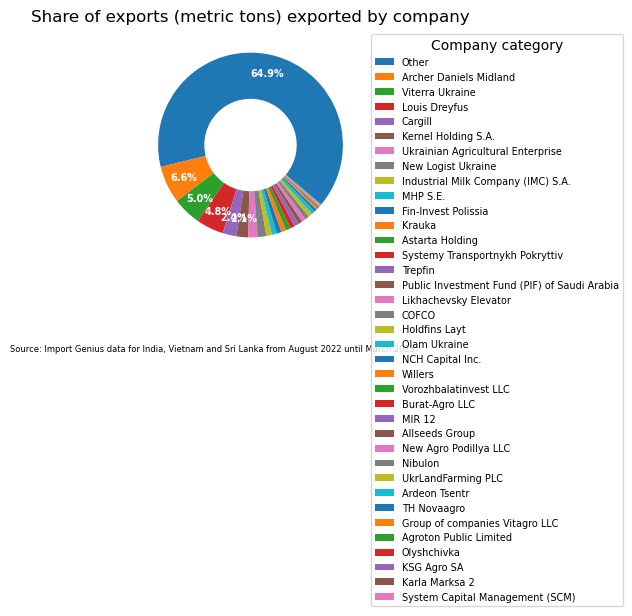

In [18]:
plot_all_period(ig_c, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

### TABLE WITH EXPORTS BY COMPANY (ALL COMPANIES INCLUDED)

Now we get the same table but with the specific companies that are not in the top 10 disaggregated.

In [19]:
ig_c["company_all"] = ig_c["company_std"]
for idx, row in ig_c.iterrows():
    if row["company_std"] == "Other":
        ig_c["company_all"][idx] = ig_c["shipper"][idx]

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_50214/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_c["company_all"][idx] = ig_c["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_50214/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_c["company_all"][idx] = ig_c["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_50214/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [20]:
ig_all_comp = cargo_grouping(ig_c, ["year", "month", "company_all"], ["weight_ton"], ["year", "month", "weight_ton"], True, {"weight_ton": "sum"})
ig_all_comp["date"] = ig_all_comp["month"].astype(str) + "/" + ig_all_comp["year"].astype(str)
ig_all_comp = ig_all_comp.sort_values(by=["year", "month", "weight_ton"], ascending=[True, True, False])
translate_column(ig_all_comp, "company_all", "google", source="uk", target="en")

KeyboardInterrupt: 

In [ ]:
ig_all_translate = ig_all_comp[["date", "company_all", "company_all_gt", "weight_ton"]]
ig_all_translate.to_csv('../data/total_exports_by_company.csv', index=False)
ig_all_translate[ig_all_translate["date"] == "10/2022"].head()

,date,company_all,company_all_gt,weight_ton
43,10/2022,Kernel Holding S.A.,Kernel Holding S.A.,41346.619
41,10/2022,HS Airlines,HS Airlines,21151.790
44,10/2022,MHP S.E.,MHP S.E.,9660.518
46,10/2022,Smartsystems,Smartsystems,9155.761
42,10/2022,Karla Marksa 2,Karl Marx 2,8742.430


In [ ]:
ig_all_translate

,date,company_all,company_all_gt,weight_ton
1,8/2022,ТОВ АГРАРНА КОМПАНІЯ ФОРВАРД 42736 СУМСЬКА ОБЛ...,TOV AGRICULTURAL COMPANY FORWARD 42736 SUMS RE...,143.262
3,8/2022,ТОВ БАЙРАК ТРЕЙД 2022 УКРАЇНА 65078 ОДЕСЬКА ОБ...,BAYRAK TRADE LLC 2022 UKRAINE 65078 ODESKA REG...,128.500
4,8/2022,ТОВ УКРОЛІЯ ВУЛ ШОВКОВИЧНА БУДИНОК 42 44 ОФІС ...,LLC UKROLYA STREET SHOVKOVYCHNA BUILDING 42 44...,115.060
2,8/2022,ТОВ АРСБУК УКРАЇНА ЧЕРНІВЕЦЬКА ОБЛ МІСТО ЧЕРНІ...,LLC ARSBUK UKRAINE CHERNIVETSKA OBL CITY OF CH...,70.180
0,8/2022,ПП ВІКТОР І К 27552 УКРАЇНА КІРОВОГРАДСЬКА ОБЛ...,PP VIKTOR I K 27552 UKRAINE KIROVOGRADSKA OBL ...,23.500
...,...,...,...,...
292,3/2023,ТОВ РСМ ПЛЮС 36020 ПОЛТАВА ВУЛ ОРЛИКА ПИЛИПА Б...,LLC RSM PLUS 36020 POLTAVA ORLYKA STREET PYLYP...,54.000
286,3/2023,ТОВ БУДЛІС ЕКСПОРТ 41023 СУМСЬКА ОБЛ ШОСТКИНСЬ...,BUDLYS EXPORT LLC 41023 SUMSKA REGION SHOSTKIN...,53.870
283,3/2023,ТОВ АГРО СЕРВІС НЕРУБАЙСЬКЕ 67661 ОДЕСЬКА ОБЛ ...,AGRO SERVICE NERUBAYSKE LLC 67661 ODESK OBL BI...,52.000
296,3/2023,ТОВ ФАКТОРІЯ АГРО ВУЛ НОВОПРОМИСЛОВА БУД 1 УКР...,TOV FAKTORIA AGRO VUL NOVOPROMYSLOVA BUILDING ...,48.000


### EXPLORATORY ANALYSIS FOR MANUAL COMPANY MATCHING

In [ ]:
tempo = cargo_grouping(ig_c, ["company_all"], ["weight_ton"], ["weight_ton"], True, {"weight_ton": "sum"})
tempo.sort_values(by=["weight_ton"], ascending=False)[:40]

,company_all,weight_ton
380,ТОВ АДМ ЮКРЕЙН УКРАЇНА 04070 М КИЇВ ПОДІЛЬСЬКИ...,287217.480
24,Viterra Ukraine,231409.341
607,ТОВ ЛУЇ ДРЕЙФУС КОМПАНІ УКРАЇНА 01001 М КИЇВ П...,133320.848
11,Kernel Holding S.A.,95709.952
1101,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЛУЇ ДР...,89738.830
1171,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СІЛЬСЬ...,76606.540
652,ТОВ НЬЮ ЛОГІСТ ЮКРЕЙН 65005 УКРАЇНА М ОДЕСА ВУ...,61860.156
6,Cargill,58581.219
404,ТОВ АТ КАРГІЛЛ 03150 М КИЇВ ВУЛ ВЕЛИКА ВАСИЛЬК...,53060.343
8,Industrial Milk Company (IMC) S.A.,45330.929


In [ ]:
tempo.loc[666]["company_all"]

'ТОВ ОЛАМ УКРАЇНА 03057 М КИЇВ ВУЛ МЕТАЛІСТІВ БУД 20 ЛІТ Т'

In [ ]:
ig_c[ig_c["shipper"] == 'ТОВ АДМ ЮКРЕЙН УКРАЇНА 04070 М КИЇВ ПОДІЛЬСЬКИЙ Р Н ВУЛ ПЕТРА САГАЙДАЧНОГО БУД 16 А']["product"]

422     пшениця і суміш пшениці та жита (меслин): - ін...
423     пшениця і суміш пшениці та жита (меслин): - ін...
424     пшениця і суміш пшениці та жита (меслин): - ін...
747                                     кукурудза: - інша
752                                     кукурудза: - інша
753                                     кукурудза: - інша
754                                     кукурудза: - інша
4275                                    кукурудза: - інша
4276                                    кукурудза: - інша
4277                                    кукурудза: - інша
4278                                    кукурудза: - інша
4279                                    кукурудза: - інша
4280                                    кукурудза: - інша
4281                                    кукурудза: - інша
4282                                    кукурудза: - інша
4721                                    кукурудза: - інша
4722                                    кукурудза: - інша
5020          

In [ ]:
deals_c[deals_c["Top parent companies"].str.lower().str.contains("olam")]["Top parent companies"]

Series([], Name: Top parent companies, dtype: object)

In [ ]:
sorted(deals_c["Top parent companies"].unique())

['AGR Invest Holding Ltd#40757#',
 'AGT Capital Management Ltd.#41248#',
 'Agro Ukraina AB#44407#',
 'Agro-Podillya i K LLC#43419#',
 'AgroGeneration#656#',
 'AgroGeneration#656#|Azent Ltd.#40783#',
 'AgroGeneration#656#|L`ost Dominic#41121#|Mandua Catrin#41123#|Claud Mandua#41124#',
 'Agromino A/S#4970#',
 'Agroton Public Limited#38647#',
 'Agrovista Limited#41491#',
 'Akella Impex LP#5042#',
 'Aladin tekstil ve hiyim iuriunleri tidzharet LLC#44904#',
 'Alberto Kazoni#5062#|Kyrylenko Volodymyr#5063#|Vorotyntsev Vitaliy#5064#',
 'Albus Gunter#41907#',
 'Alexander Wolters#41898#',
 'Alpha-Capital LLC#44409#',
 'Aslan Global Management#1779#',
 'BKW Group LLC#43027#',
 'Berend Popke van der Velde#40762#|Herrit Tonkens#40763#|Huzinha Kornelius Hendrick#40764#|Oxana Kryachko#40765#',
 'Berry Farma ApS#5060#',
 'Bitex Trade Ltd.#43046#',
 'Bontrup Holding#4963#',
 'Brunner&Partner LLC#5047#|Glendore Holding LLC#5048#',
 "Brykivs'ke LLC#43422#",
 'CNBM International energy PTE.LTD#44677#',
 

### DIFFERENCE IN EXPORTS BETWEEN IG AND BSGI

We do some analysis to see why we have differences in weights between IG and BSGI

In [ ]:
ig_g = cargo_grouping(ig_c, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_g = cargo_grouping(bsgi_asia, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,8/2022,480.5,19100
1,9/2022,101447.0,106500
2,10/2022,204440.4,198789
3,11/2022,16395.7,6010
4,12/2022,96214.6,136500
5,1/2023,131385.2,92500
6,2/2023,74775.0,73444
7,3/2023,62737.6,94000


Text(-90, -60, 'Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.')

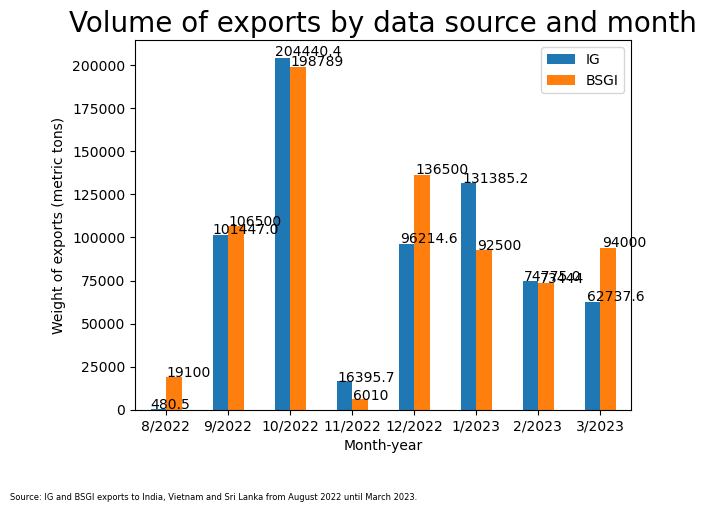

In [ ]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

We do the same for Vietnam

In [ ]:
ig_vietnam = ig_c.loc[ig_c.loc[:, "country"] == "в єтнам"]
ig_g = cargo_grouping(ig_vietnam, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_vietnam = bsgi_asia.loc[bsgi_asia.loc[:, "country_en"] == "viet nam"]
bsgi_g = cargo_grouping(bsgi_vietnam, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", how="outer", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,8/2022,119.4,NaN
1,9/2022,575.6,NaN
2,10/2022,110144.8,116789.0
3,11/2022,7542.4,NaN
4,12/2022,808.0,NaN
5,1/2023,520.0,NaN
6,2/2023,423.1,NaN
7,3/2023,54864.0,52000.0


Text(-90, -60, 'Source: IG and BSGI exports to Vietnam from August 2022 until March 2023.')

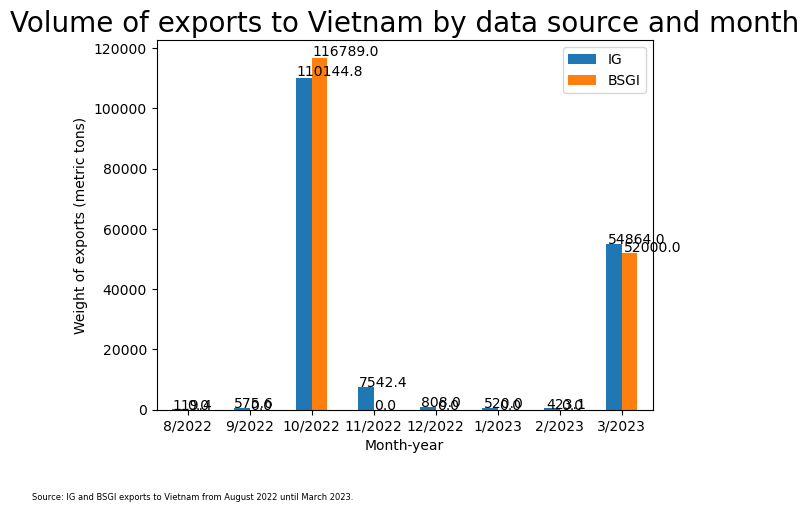

In [ ]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports to Vietnam by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to Vietnam from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

In [ ]:
# dates = ["2022-08-01", "2022-09-01", "2022-10-01", "2022-11-01", "2022-12-01", "2023-01-01", "2023-02-01", "2023-03-01", "2023-04-01"]
# ig_test = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]
# for i in range(len(dates)-1):
#     ig_oct = ig_test.loc[(ig_test.loc[:, "date"] >= dates[i]) & (ig_test.loc[:, "date"] < dates[i+1])]
#     bsgi_oct = bsgi_asia.loc[(bsgi_asia.loc[:, "date"] >= dates[i]) & (bsgi_asia.loc[:, "date"] < dates[i+1])]
#     print(dates[i])
#     print("IG tons:", ig_oct.loc[ig_oct.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
#     print("BSGI tons:",bsgi_oct.loc[bsgi_oct.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

In [ ]:
bsgi.loc[(bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01") & (bsgi.loc[:, "country_en"] == "viet nam")].head()

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
717,Outbound,381,C FAITH,9575163,Odesa,viet nam,wheat,56789,2022-10-24,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам
819,Outbound,287,CORNELIA M,9490117,Yuzhny/Pivdennyi,viet nam,wheat,60000,2022-10-08,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам
